# Task2: Vision Language Alingment with CLIP Style Contrastive Learning

## Installing libs

In [24]:
# !pip install scikit-learn matplotlib tqdm kagglehub

## Importing Libs

In [25]:
import os
import math
import random
from pathlib import Path
from typing import List, Tuple
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
import torchvision.models as models

from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity



In [26]:
import kagglehub
path = kagglehub.dataset_download("adityajn105/flickr8k")
print("Path to dataset files:", path)

100%|██████████| 1.04G/1.04G [00:10<00:00, 102MB/s] 

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/adityajn105/flickr8k/versions/1


## Configs

In [31]:
import csv

TXT = "dataset/flickr8k/captions.txt"
CSV = "dataset/flickr8k/captions.csv"

rows = []

with open(TXT, "r", encoding="utf-8") as f:
    for line in f:
        line = line.strip()
        
        # skip empty lines and duplicate headers
        if not line or line.lower() == "image,caption":
            continue

        # Split into exactly TWO columns
        img, cap = line.split(",", 1)

        rows.append((img.strip(), cap.strip()))

# Write to CSV
with open(CSV, "w", newline="", encoding="utf-8") as f:
    writer = csv.writer(f)
    writer.writerow(["image", "caption"])
    writer.writerows(rows)

print("DONE — captions.csv created at:", CSV)
print("Total rows:", len(rows))


DONE — captions.csv created at: datasets/flickr8k/captions.csv
Total rows: 40455


In [32]:
DATA_ROOT = "./dataset/flickr8k"  
CSV_FILE = "captions.csv"                       
OUT_DIR = "outputs_task2"
IMAGE_SIZE = 224
BATCH_SIZE = 64
EPOCHS = 10
LR = 1e-4
EMBED_DIM = 256
TEMPERATURE = 0.07
DEVICE = "cuda" if __import__('torch').cuda.is_available() else "cpu"
NUM_WORKERS = 4

os.makedirs(OUT_DIR, exist_ok=True)

## Preparing Dataset

In [44]:
class ImageTextDataset(Dataset):
    def __init__(self, csv_path: str, data_root: str = "", transform=None):
        import csv
        self.data = []
        self.data_root = data_root
        with open(csv_path, "r", encoding="utf-8") as f:
            reader = csv.reader(f)
            header = next(reader)
            for row in reader:
                if len(row) < 2:
                    continue
                img, cap = row[0].strip(), row[1].strip()
                self.data.append((img, cap))
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path, caption = self.data[idx]
        path = os.path.join(self.data_root,"Images", img_path) if not os.path.isabs(img_path) else img_path
        img = Image.open(path).convert("RGB")
        if self.transform:
            img = self.transform(img)
        return img, caption, os.path.basename(img_path)

## Transforms

In [34]:
train_transform = T.Compose([
    T.RandomResizedCrop(IMAGE_SIZE, scale=(0.7,1.0)),
    T.RandomHorizontalFlip(),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229,0.224,0.225])
])

val_transform = T.Compose([
    T.Resize(256),
    T.CenterCrop(IMAGE_SIZE),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229,0.224,0.225])
])


## Text encoder

In [35]:
class SimpleTokenizer:
    def __init__(self, texts: List[str], min_freq: int = 1):
        from collections import Counter
        toks = []
        for t in texts:
            toks.extend(self._tokenize(t))
        counter = Counter(toks)
        self.vocab = {"<PAD>":0, "<UNK>":1}
        for w,c in counter.items():
            if c >= min_freq and w not in self.vocab:
                self.vocab[w] = len(self.vocab)
        self.inv_vocab = {i:w for w,i in self.vocab.items()}

    def _tokenize(self, text: str):
        return text.lower().split()

    def encode(self, text: str, max_len: int = 32):
        toks = self._tokenize(text)[:max_len]
        ids = [self.vocab.get(t, self.vocab["<UNK>"]) for t in toks]
        if len(ids) < max_len:
            ids = ids + [self.vocab["<PAD>"]] * (max_len - len(ids))
        return ids

class TextEncoder(nn.Module):
    def __init__(self, vocab_size:int, emb_dim:int=256, max_len:int=32, nhead=4, nlayers=2):
        super().__init__()
        self.token_embed = nn.Embedding(vocab_size, emb_dim, padding_idx=0)
        self.pos_embed = nn.Parameter(torch.randn(1, max_len, emb_dim))
        encoder_layer = nn.TransformerEncoderLayer(d_model=emb_dim, nhead=nhead)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=nlayers)
        self.max_len = max_len
        self.fc = nn.Linear(emb_dim, EMBED_DIM)

    def forward(self, x):
        # x: (B, L) tokens
        emb = self.token_embed(x) + self.pos_embed[:, :x.size(1), :]
        emb = emb.permute(1,0,2)  # (L,B,E) for transformer
        out = self.transformer(emb)  # (L,B,E)
        out = out.permute(1,0,2)  # (B,L,E)
        # simple pooling: mean excluding PAD
        mask = (x != 0).unsqueeze(-1).float()
        summed = (out * mask).sum(1)
        lengths = mask.sum(1).clamp(min=1.0)
        pooled = summed / lengths
        out = self.fc(pooled)
        return out

## Image encoder with projection head

In [36]:
class ImageEncoder(nn.Module):
    def __init__(self, embed_dim=EMBED_DIM, pretrained=True):
        super().__init__()
        backbone = models.resnet50(pretrained=pretrained)
        # remove fc
        modules = list(backbone.children())[:-1]
        self.backbone = nn.Sequential(*modules)  # outputs (B,2048,1,1)
        self.fc = nn.Linear(2048, embed_dim)

    def forward(self, x):
        x = self.backbone(x)  # (B,2048,1,1)
        x = x.flatten(1)
        x = self.fc(x)
        return x

## Projection + normalization

In [37]:
class MiniCLIP(nn.Module):
    def __init__(self, vocab_size, max_len=32):
        super().__init__()
        self.img_enc = ImageEncoder()
        self.txt_enc = TextEncoder(vocab_size, emb_dim=256, max_len=max_len)

    def forward(self, images, tokens):
        img_feats = self.img_enc(images)  # (B,E)
        txt_feats = self.txt_enc(tokens)  # (B,E)
        img_norm = F.normalize(img_feats, dim=1)
        txt_norm = F.normalize(txt_feats, dim=1)
        return img_norm, txt_norm

## Contrastive Loss (NT-Xent)

In [38]:
def contrastive_loss(img_emb, txt_emb, temperature=TEMPERATURE):
    # img_emb, txt_emb: (B,E) normalized
    logits = img_emb @ txt_emb.t() / temperature  # (B,B)
    labels = torch.arange(logits.size(0), device=logits.device)
    loss_i2t = F.cross_entropy(logits, labels)
    loss_t2i = F.cross_entropy(logits.t(), labels)
    return (loss_i2t + loss_t2i) / 2.0

## Utilities: collate, training, eval

In [50]:
from functools import partial

def collate_fn(batch, tokenizer, max_len=32, transform=None):
    imgs, caps, names = zip(*batch)
    imgs = torch.stack(imgs)
    tokens = [tokenizer.encode(c, max_len=max_len) for c in caps]
    tokens = torch.tensor(tokens, dtype=torch.long)
    return imgs, tokens, names

@torch.no_grad()
def compute_embeddings(model, loader, device):
    model.eval()
    all_img = []
    all_txt = []
    names = []
    for imgs, toks, nms in tqdm(loader, desc="Embedding"):
        imgs = imgs.to(device)
        toks = toks.to(device)
        img_emb, txt_emb = model(imgs, toks)
        all_img.append(img_emb.cpu())
        all_txt.append(txt_emb.cpu())
        names.extend(nms)
    all_img = torch.cat(all_img)
    all_txt = torch.cat(all_txt)
    return all_img.numpy(), all_txt.numpy(), names

def retrieval_metrics(img_embs, txt_embs, topk=(1,5,10)):
    # compute cosine similarity
    sims = img_embs @ txt_embs.T
    n = sims.shape[0]
    ranks = np.argsort(-sims, axis=1)
    recall = {}
    for k in topk:
        correct = 0
        for i in range(n):
            # ground truth is at same index i
            if i in ranks[i,:k]:
                correct += 1
        recall[f"R@{k}"] = correct / n
    # text->image
    ranks_t2i = np.argsort(-sims.T, axis=1)
    for k in topk:
        correct = 0
        for i in range(n):
            if i in ranks_t2i[i,:k]:
                correct += 1
        recall[f"t2i_R@{k}"] = correct / n
    return recall

## Training loop

In [40]:
def train_loop(model, train_loader, val_loader, tokenizer, device, epochs=EPOCHS, lr=LR):
    model = model.to(device)
    opt = torch.optim.AdamW(model.parameters(), lr=lr)
    best_val = 0.0
    for epoch in range(1, epochs+1):
        model.train()
        running_loss = 0.0
        for imgs, toks, _ in tqdm(train_loader, desc=f"Epoch {epoch}"):
            imgs = imgs.to(device)
            toks = toks.to(device)
            img_emb, txt_emb = model(imgs, toks)
            loss = contrastive_loss(img_emb, txt_emb)
            opt.zero_grad()
            loss.backward()
            opt.step()
            running_loss += loss.item() * imgs.size(0)
        avg_loss = running_loss / len(train_loader.dataset)
        # validate
        img_embs, txt_embs, _ = compute_embeddings(model, val_loader, device)
        metrics = retrieval_metrics(img_embs, txt_embs)
        val_r1 = metrics['R@1']
        print(f"Epoch {epoch}: Train Loss {avg_loss:.4f} | Val R@1 {val_r1:.4f}")
        # checkpoint
        if val_r1 > best_val:
            best_val = val_r1
            torch.save({
                'model_state': model.state_dict(),
                'tokenizer_vocab': tokenizer.vocab
            }, os.path.join(OUT_DIR, 'best_mini_clip.pth'))
    print("Training finished.")



## t-SNE visualization

In [59]:
def plot_tsne(img_embs, txt_embs, names, save_path=os.path.join(OUT_DIR,'tsne.png')):
    feats = np.concatenate([img_embs, txt_embs], axis=0)
    labels = ['img']*img_embs.shape[0] + ['txt']*txt_embs.shape[0]
    tsne = TSNE(n_components=2, perplexity=30, init='pca', random_state=42)
    low = tsne.fit_transform(feats)
    plt.figure(figsize=(8,8))
    plt.scatter(low[:img_embs.shape[0],0], low[:img_embs.shape[0],1], label='images', alpha=0.6)
    plt.scatter(low[img_embs.shape[0]:,0], low[img_embs.shape[0]:,1], label='texts', alpha=0.6)
    plt.legend()
    plt.title('t-SNE of image and text embeddings')
    plt.show()
    plt.savefig(save_path, dpi=200)
    plt.close()

## Zero-shot classification using text prompts

In [67]:
@torch.no_grad()
def zero_shot_classify(model, class_prompts, dataloader, tokenizer, device):
    model.eval()

    # Encode text prompts
    token_ids = [tokenizer.encode(p) for p in class_prompts]
    token_ids = torch.tensor(token_ids, dtype=torch.long).to(device)

    # Run text encoder directly
    txt_embs = model.txt_enc(token_ids)          # (num_prompts, embed_dim)
    txt_embs = F.normalize(txt_embs, dim=1)      # normalize
    txt_embs = txt_embs.cpu().numpy()

    # Compute image embeddings
    img_embs, _, names = compute_embeddings(model, dataloader,DEVICE)
    img_embs = img_embs                           # already normalized

    # Similarity: (num_images, num_prompts)
    sims = img_embs @ txt_embs.T

    # Predictions: best matching prompt for each image
    preds = sims.argmax(axis=1)

    return preds, names


In [45]:
# Load full dataset
csv_path = os.path.join(DATA_ROOT, CSV_FILE)
raw_ds = ImageTextDataset(csv_path, data_root=DATA_ROOT, transform=train_transform)

# Split train/val
n = len(raw_ds)
val_size = int(0.1 * n)
train_size = n - val_size
train_ds, val_ds = torch.utils.data.random_split(raw_ds, [train_size, val_size])

# Build tokenizer
all_caps = [cap for (_, cap, _) in raw_ds]
tokenizer = SimpleTokenizer(all_caps)

# Re-wrap datasets with transforms
train_ds.dataset.transform = train_transform
val_ds.dataset.transform = val_transform

# DataLoaders
train_loader = DataLoader(
    train_ds, batch_size=BATCH_SIZE, shuffle=True,
    num_workers=NUM_WORKERS,
    collate_fn=lambda b: collate_fn(b, tokenizer)
)

val_loader = DataLoader(
    val_ds, batch_size=BATCH_SIZE, shuffle=False,
    num_workers=NUM_WORKERS,
    collate_fn=lambda b: collate_fn(b, tokenizer)
)

print("Train samples:", len(train_ds))
print("Val samples:", len(val_ds))


Train samples: 36410
Val samples: 4045


In [51]:
vocab_size = len(tokenizer.vocab)
model = MiniCLIP(vocab_size)
train_loop(model, train_loader, val_loader, tokenizer,DEVICE)

Embedding: 100%|██████████| 64/64 [00:05<00:00, 11.07it/s]


Epoch 1: Train Loss 2.2652 | Val R@1 0.0638


Embedding: 100%|██████████| 64/64 [00:05<00:00, 11.06it/s]


Epoch 2: Train Loss 1.0980 | Val R@1 0.1117


Embedding: 100%|██████████| 64/64 [00:05<00:00, 11.28it/s]


Epoch 3: Train Loss 0.6896 | Val R@1 0.1407


Embedding: 100%|██████████| 64/64 [00:05<00:00, 11.10it/s]


Epoch 4: Train Loss 0.4779 | Val R@1 0.1745


Embedding: 100%|██████████| 64/64 [00:05<00:00, 11.12it/s]


Epoch 5: Train Loss 0.3723 | Val R@1 0.1807


Embedding: 100%|██████████| 64/64 [00:05<00:00, 11.11it/s]


Epoch 6: Train Loss 0.3052 | Val R@1 0.1993


Embedding: 100%|██████████| 64/64 [00:05<00:00, 11.08it/s]


Epoch 7: Train Loss 0.2580 | Val R@1 0.2037


Embedding: 100%|██████████| 64/64 [00:05<00:00, 11.39it/s]


Epoch 8: Train Loss 0.2290 | Val R@1 0.2176


Embedding: 100%|██████████| 64/64 [00:05<00:00, 11.26it/s]


Epoch 9: Train Loss 0.2092 | Val R@1 0.2287


Embedding: 100%|██████████| 64/64 [00:05<00:00, 10.99it/s]


Epoch 10: Train Loss 0.1921 | Val R@1 0.2272
Training finished.


In [55]:
torch.save({
    "model": model.state_dict(),
    "vocab": tokenizer.vocab
}, os.path.join(OUT_DIR, "best_model.pth"))


In [60]:
# Load best model
ckpt = torch.load(os.path.join(OUT_DIR, "best_model.pth"), map_location=DEVICE)
model = MiniCLIP(len(ckpt["vocab"]))
model.load_state_dict(ckpt["model"])
tokenizer.vocab = ckpt["vocab"]
model.to(DEVICE)

# Compute embeddings
img_embs, txt_embs, names = compute_embeddings(model, val_loader,DEVICE)

# Retrieval metrics
metrics = retrieval_metrics(img_embs, txt_embs)
print("Retrieval:", metrics)

# t-SNE
# plot_tsne(img_embs, txt_embs,names)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast

Retrieval: {'R@1': 0.22719406674907294, 'R@5': 0.48627935723114957, 'R@10': 0.5985166872682324, 't2i_R@1': 0.2242274412855377, 't2i_R@5': 0.4892459826946848, 't2i_R@10': 0.6111248454882571}


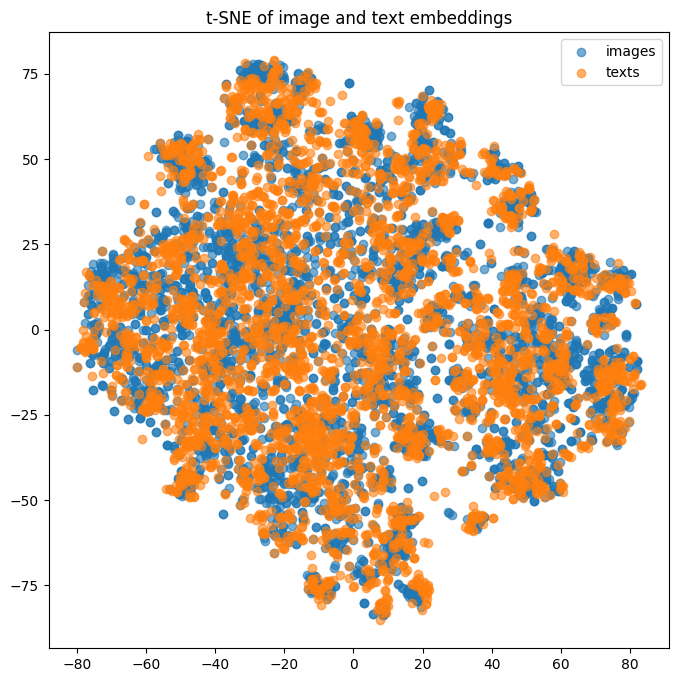

In [61]:
plot_tsne(img_embs, txt_embs,names)

In [68]:
prompts = [
    "a dog running",
    "a person cooking",
    "a red car",
    "a cat sleeping"
]

preds, image_ids = zero_shot_classify(model, prompts, val_loader, tokenizer,DEVICE)

for p, img in zip(preds[:10], image_ids[:10]):
    print(img, "→", prompts[p])


Embedding: 100%|██████████| 64/64 [00:05<00:00, 11.03it/s]

3372340429_91c4f4af30.jpg → a dog running
267836606_bbea2267c8.jpg → a dog running
861608773_bdafd5c996.jpg → a dog running
2560278143_aa5110aa37.jpg → a dog running
2890731828_8a7032503a.jpg → a cat sleeping
1390268323_2c8204e91c.jpg → a red car
2987096101_a41896187a.jpg → a person cooking
2858903676_6278f07ee3.jpg → a red car
3596959859_a7cb1e194b.jpg → a cat sleeping
3084149186_4bc08b0752.jpg → a person cooking


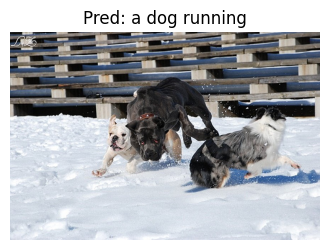

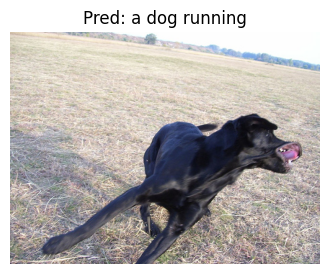

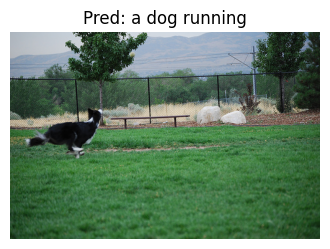

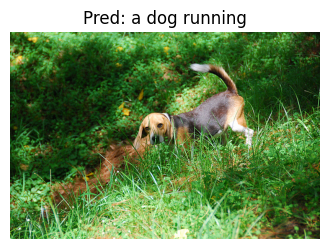

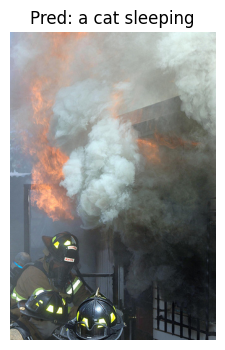

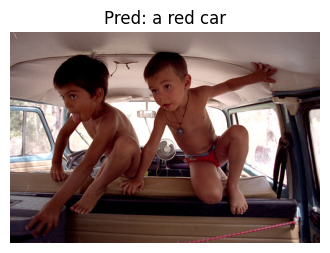

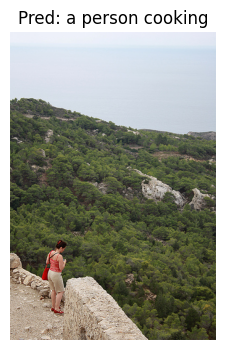

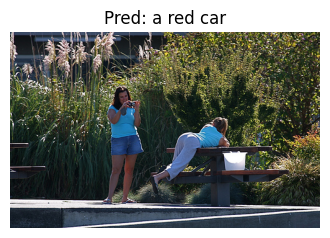

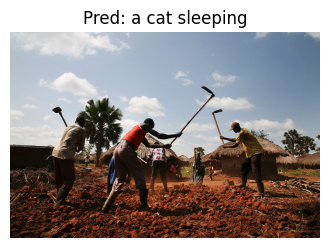

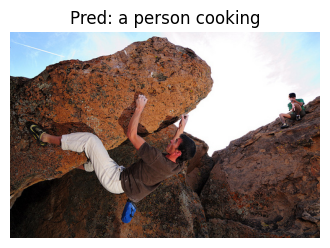

In [69]:
from PIL import Image
import matplotlib.pyplot as plt
import os

def show_zero_shot_results(preds, image_ids, prompts, data_root, n=10):
    """
    preds: predicted prompt indices
    image_ids: filenames returned from compute_embeddings
    prompts: list of text prompts used in zero-shot
    data_root: folder containing Images/
    n: number of samples to show
    """

    for i in range(min(n, len(preds))):
        img_name = image_ids[i]
        pred_label = prompts[preds[i]]

        # Construct full path to image
        img_path = os.path.join(data_root, "Images", img_name)

        # Load image
        img = Image.open(img_path).convert("RGB")

        # Render
        plt.figure(figsize=(4,4))
        plt.imshow(img)
        plt.axis("off")
        plt.title(f"Pred: {pred_label}")
        plt.show()


show_zero_shot_results(
    preds,
    image_ids,
    prompts,
    DATA_ROOT,     # <-- this should be /workspace/datasets/flickr8k
    n=10           # number of samples to display
)
